<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/GRU_NN_Gradient_Boosting_Ensemble_With_Complete_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import listdir

files = listdir('/content/drive/MyDrive/amex-default-prediction/data/customer_train/')


In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [3]:
pip install tensorflow_decision_forests


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 5.1 MB/s 
     |████████████████████████████████| 511.7 MB 4.9 kB/s 
     |████████████████████████████████| 438 kB 68.4 MB/s 
     |████████████████████████████████| 1.6 MB 56.0 MB/s 
     |████████████████████████████████| 5.8 MB 55.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [4]:
import gc 

import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from keras.layers import GRU, Dense
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf



In [5]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'
AGG_DATA_ABS_PATH = '/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet'

In [6]:
!unzip -o /content/drive/MyDrive/amex-default-prediction/data/amex-default-prediction.zip \
 train_labels.csv

Archive:  /content/drive/MyDrive/amex-default-prediction/data/amex-default-prediction.zip
  inflating: train_labels.csv        


In [7]:
train_labels = pd.read_csv(TRAIN_LABELS_PATH)

In [8]:
train_labels.shape

(458913, 2)

In [9]:
agg_dataset = pd.read_parquet(path=AGG_DATA_ABS_PATH)

In [10]:
enc_agg = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
agg_dataset[['D_63_last', 'D_64_last']]=enc_agg.fit(agg_dataset[['D_63_last', 'D_64_last']])
agg_dataset[['D_63_last', 'D_64_last']]=enc_agg.transform(agg_dataset[['D_63_last', 'D_64_last']])
agg_dataset.fillna(0, inplace=True)



In [11]:
agg_dataset.drop(axis=1, columns=['target'], inplace=True)

In [12]:
agg_dataset.shape

(458913, 919)

In [13]:
def append_label(source_df):
  return pd.merge(left=source_df, right=train_labels, how='inner')

In [14]:
def my_generator():
    for f in files:      
      X = pd.DataFrame()
      Y = pd.DataFrame()
      df_tmp = pd.read_parquet('/content/drive/MyDrive/amex-default-prediction/data/customer_train/' + f)
      df_tmp = append_label(df_tmp)
      enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      df_tmp[['D_63', 'D_64']]=enc.fit(df_tmp[['D_63', 'D_64']])

      df_tmp[['D_63', 'D_64']]=enc.transform(df_tmp[['D_63', 'D_64']])
      df_tmp.fillna(0, inplace=True)

      X= X.append(df_tmp.loc[:, ~df_tmp.columns.isin(['target'])])
      X = X[X.groupby('customer_ID')['customer_ID'].transform('count') == 13]
      X_Cust = pd.DataFrame(X['customer_ID'].unique(), columns=['customer_ID'])
      Y = pd.merge(left=X_Cust, right=train_labels, how='inner')

      X_Agg = pd.merge(left=X_Cust, right=agg_dataset, how ='inner')
      
      X.drop(axis=1, columns=['customer_ID', 'S_2'], inplace=True)
      X = X.values.reshape(X_Cust.shape[0], 13, 188)
      Y.drop(axis=1, columns='customer_ID', inplace=True)

      X_Agg.drop(axis=1, columns='customer_ID', inplace=True)

      print(f'X shape = {X.shape}')
      yield {"input_1": X, "input_2": X_Agg.to_numpy()}, Y.to_numpy()
      




In [15]:
def my_input_fn(epochs):
    dataset = tf.data.Dataset.from_generator(lambda: my_generator(),
                                             output_types=({"input_1": tf.float64, "input_2": tf.float64}, tf.int64),
                                            output_shapes=({"input_1": tf.TensorShape([None, 13, 188]), "input_2" : tf.TensorShape([None, 918])},
                                                           tf.TensorShape([None, 1])))

    dataset = dataset.repeat(epochs)
    # dataset = dataset.batch(32)
    return dataset


In [16]:
f1_metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)

first_input = tf.keras.Input(shape=(13, 188))
first_dense_1 = GRU(64, dropout=0.1, recurrent_dropout=0.5)(first_input)
first_dense_2 = Dense(64, activation='sigmoid')(first_dense_1)

second_input = tf.keras.Input(shape=(918))
second_dense_1 = Dense(128, activation='relu')(second_input)
second_dense_2 = Dense(64, activation='sigmoid')(second_dense_1)


merge_one = tf.keras.layers.concatenate([first_dense_2, second_dense_2])

output_layer = Dense(1, activation='sigmoid')(merge_one)

nn_model = tf.keras.models.Model(inputs=[first_input, second_input], outputs=output_layer)
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


nn_without_head = tf.keras.Model(inputs=[first_input, second_input], outputs=merge_one)
df_and_nn_model = tfdf.keras.GradientBoostedTreesModel(preprocessing=nn_without_head, check_dataset=False)



Use /tmp/tmpcx_1b7q7 as temporary training directory


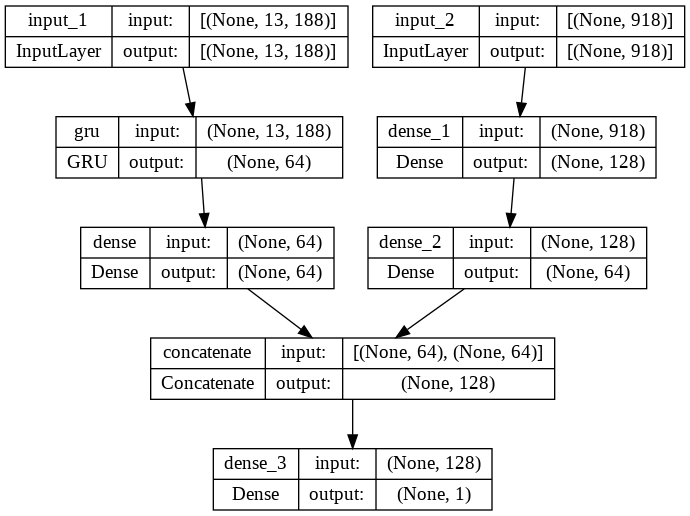

In [17]:
from keras.utils.vis_utils import plot_model

plot_model(nn_model, to_file="/tmp/model.png", show_shapes=True)

In [18]:

dataset = my_input_fn(1)



In [19]:
nn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13, 188)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 918)]        0           []                               
                                                                                                  
 gru (GRU)                      (None, 64)           48768       ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          117632      ['input_2[0][0]']                
                                                                                              

In [21]:
weight_for_0 = (1 / 75) * (100 / 2.0)
weight_for_1 = (1 / 25) * (100 / 2.0)
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

class_weight = {0: weight_for_0, 1: weight_for_1}

nn_model.fit(dataset, epochs=10,  class_weight=class_weight)

Weight for class 0: 0.67
Weight for class 1: 2.00
Epoch 1/10
X shape = (7508, 13, 188)
      1/Unknown - 11s 11s/step - loss: 0.7461 - accuracy: 0.7698X shape = (41994, 13, 188)
      2/Unknown - 34s 23s/step - loss: 0.6819 - accuracy: 0.7682X shape = (42089, 13, 188)
      3/Unknown - 59s 24s/step - loss: 0.6639 - accuracy: 0.7237X shape = (41911, 13, 188)
      4/Unknown - 79s 23s/step - loss: 0.6517 - accuracy: 0.6281X shape = (42029, 13, 188)
      5/Unknown - 100s 22s/step - loss: 0.6391 - accuracy: 0.6215X shape = (42098, 13, 188)
      6/Unknown - 121s 22s/step - loss: 0.6239 - accuracy: 0.6481X shape = (42038, 13, 188)
      7/Unknown - 143s 22s/step - loss: 0.6081 - accuracy: 0.6785X shape = (42037, 13, 188)
8/8 [==============================] - 161s 21s/step - loss: 0.5922 - accuracy: 0.7053
Epoch 2/10
X shape = (7508, 13, 188)
8/8 [==============================] - 158s 22s/step - loss: 0.3846 - accuracy: 0.8649
Epoch 3/10
X shape = (7508, 13, 188)
8/8 [====================

In [22]:
df_and_nn_model.fit(dataset, verbose=1, class_weight=class_weight)

Reading training dataset...
X shape = (7508, 13, 188)
X shape = (41994, 13, 188)
X shape = (42089, 13, 188)
X shape = (41911, 13, 188)
X shape = (42029, 13, 188)
X shape = (42098, 13, 188)
X shape = (42038, 13, 188)
X shape = (42037, 13, 188)
Training dataset read in 0:02:15.861929. Found 301704 examples.
Training model...
Model trained in 0:14:15.077731
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
X shape = (7508, 13, 188)
Model compiled.


In [23]:
val_files = listdir('/content/drive/MyDrive/amex-default-prediction/data/customer_val/')

In [24]:
def my_val_generator():
    for f in val_files:      
      X = pd.DataFrame()
      Y = pd.DataFrame()
      df_tmp = pd.read_parquet('/content/drive/MyDrive/amex-default-prediction/data/customer_val/' + f)
      df_tmp = append_label(df_tmp)
      enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
      df_tmp[['D_63', 'D_64']]=enc.fit(df_tmp[['D_63', 'D_64']])

      df_tmp[['D_63', 'D_64']]=enc.transform(df_tmp[['D_63', 'D_64']])
      df_tmp.fillna(0, inplace=True)

      X= X.append(df_tmp.loc[:, ~df_tmp.columns.isin(['target'])])
      X = X[X.groupby('customer_ID')['customer_ID'].transform('count') == 13]
      X_Cust = pd.DataFrame(X['customer_ID'].unique(), columns=['customer_ID'])
      Y = pd.merge(left=X_Cust, right=train_labels, how='inner')

      X_Agg = pd.merge(left=X_Cust, right=agg_dataset, how ='inner')
      
      X.drop(axis=1, columns=['customer_ID', 'S_2'], inplace=True)
      X = X.values.reshape(X_Cust.shape[0], 13, 188)
      Y.drop(axis=1, columns='customer_ID', inplace=True)

      X_Agg.drop(axis=1, columns='customer_ID', inplace=True)

      print(f'X shape = {X.shape}')
      yield {"input_1": X, "input_2": X_Agg.to_numpy()}, Y.to_numpy()

In [25]:
def my_val_input_fn():
    dataset = tf.data.Dataset.from_generator(lambda: my_val_generator(),
                                              output_types=({"input_1": tf.float64, "input_2": tf.float64}, tf.int64),
                                            output_shapes=({"input_1": tf.TensorShape([None, 13, 188]), "input_2" : tf.TensorShape([None, 918])},
                                                            tf.TensorShape([None, 1])))

    # dataset = dataset.repeat(epochs)
    # dataset = dataset.batch(32)
    return dataset

In [26]:
val_dataset = my_val_input_fn()
df_and_nn_model.compile(metrics=["accuracy"])
print("Evaluation:", df_and_nn_model.evaluate(val_dataset))

X shape = (42194, 13, 188)
1/1 [==============================] - 26s 26s/step - loss: 0.0000e+00 - accuracy: 0.8893
Evaluation: [0.0, 0.8893444538116455]


In [ ]:
print("Evaluation:", nn_model.evaluate(val_dataset))

X shape = (42194, 13, 188)
1/1 [==============================] - 11s 11s/step - loss: 0.2122 - accuracy: 0.9070
Evaluation: [0.21218036115169525, 0.9069535732269287]
